In [133]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
import sklearn.metrics
import sklearn
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV 

from sklearn.linear_model import ElasticNetCV, ElasticNet
import xgboost  as xgb
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import datetime
from matplotlib import pyplot

df = pd.read_csv(r'C:\fair\train_data.csv',encoding='latin-1', parse_dates=['earliest_cr_line','apply_date'])
df['apply_date']=pd.to_datetime(df['apply_date'], format="%Y/%m/%d")
df['earliest_cr_line']=pd.to_datetime(df['earliest_cr_line'], format="%Y/%m/%d")

#######                       Target Variable                 ########################################
#  A default is identified by a loan status listed as in default, over 30 days late, or charged  off.#
######################################################################################################  
df['Default']=df['loan_status'].apply(lambda x: 1 if x in ('Charged Off','Default','Late (31-120 days)') else 0)

print(df['Default'].mean())

0.06592


In [134]:
##### explore data: 1 . .Missing, Distribution.. 

pd.set_option('display.width', 100)
pd.set_option('precision', 3)

#df.head(10)
print(df.shape  )
print(df.info())
print (df.describe())
print(df.groupby('loan_status').size())

vdf=pd.DataFrame(df.apply(pd.Series.nunique)).reset_index()
vdf.columns = ['attribute', 'uv_count']
cdf = pd.DataFrame(df.isnull().sum()).reset_index()
cdf.columns = ['attribute', 'na_count']
cdf['na_fraction'] = cdf['na_count']/len(df) 
adf = pd.merge(cdf, vdf, on='attribute')
print ("\n\n\tNumber of columns with over 30% NAs or single value = ", adf[ (adf['na_fraction']>0.30) | (adf['uv_count']<2) ]['attribute'].count())
print (adf)
#df[df['annual_inc'].isnull()]



(200000, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 18 columns):
id                             200000 non-null int64
loan_status                    200000 non-null object
mths_since_last_major_derog    49745 non-null float64
revol_bal                      200000 non-null int64
purpose                        200000 non-null object
addr_state                     200000 non-null object
title                          199964 non-null object
home_ownership                 200000 non-null object
application_type               200000 non-null object
verification_status_joint      111 non-null object
earliest_cr_line               199989 non-null datetime64[ns]
apply_date                     200000 non-null datetime64[ns]
verification_status            200000 non-null object
emp_length                     189735 non-null object
dti                            200000 non-null float64
emp_title                      188207 non-null object


In [132]:
##### explore data: 2 . .... 

print(df.groupby('purpose')['Default'].agg(['size', 'mean']))
print(df.groupby('emp_length')['Default'].agg(['size', 'mean']))

print (df.corr(method='pearson'))
print(df.skew())
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['id'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

pd.set_option('display.width', 500)
pd.set_option('precision', 3)

state_count =df.groupby('addr_state')['Default'].agg(['size', 'mean']).sort_values(by='size', ascending=False)
sns.set(style="darkgrid")
plt.figure(figsize=(20,15))
sns.barplot(state_count.index, state_count.size, alpha=0.9)
#sns.lineplot(x=state_count.index, y=state_count.mean, alpha=0.9)

plt.title('Frequency Distribution of states')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('State', fontsize=12)
plt.show()


KeyError: 'purpose'


 mu = 74963.18 and sigma = 51464.85



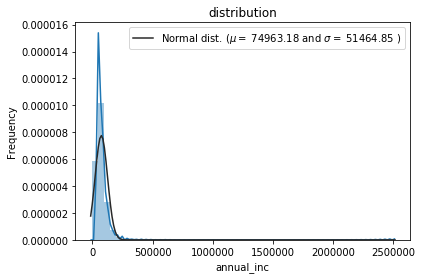

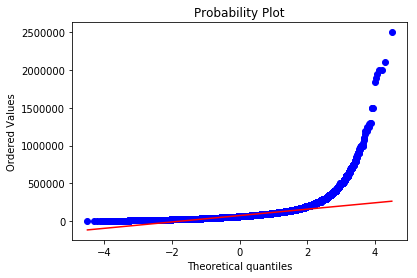


 mu = 16924.93 and sigma = 21650.49



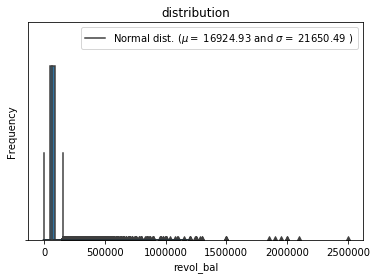

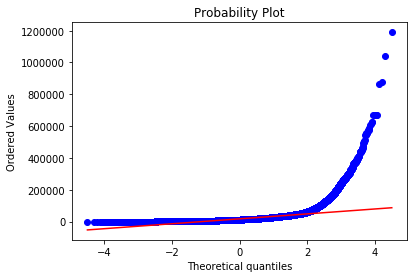


 mu = 18.15 and sigma = 23.81



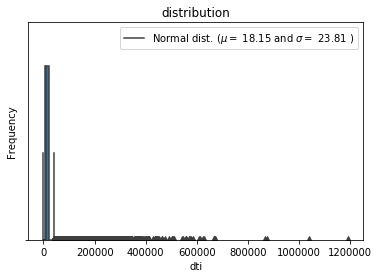

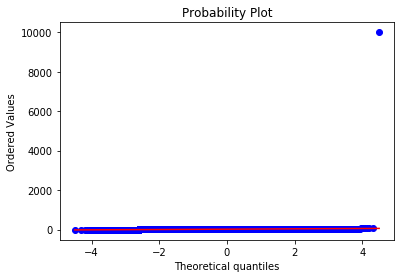

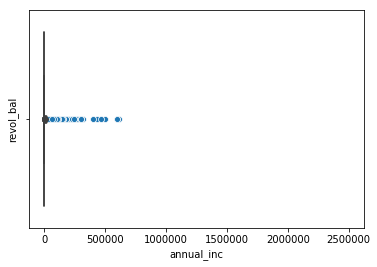

In [99]:
###  Check distribution 
def Check_Distr(var):
    sns.distplot(df[var].dropna() , fit=norm);
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[var])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
    plt.ylabel('Frequency')
    plt.title('distribution')
    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(df[var].dropna(), plot=plt)
    plt.show();
    sns.boxplot(x=df[var])
    return

Check_Distr('annual_inc')
Check_Distr('revol_bal')
Check_Distr('dti')

ax = sns.scatterplot(x="annual_inc", y="revol_bal", data=df)

In [135]:
######   Feature Engineering  #########################

#drop 2 records of annual_inc since those two recrods have other NA columns
df=df.dropna(subset=['annual_inc'])#

#drop 9 outliers
df=df[df['annual_inc']<3000000]
df=df[df['dti']<100]

####  Fill Missing Value
df['emp_length']= df['emp_length'].fillna(df['emp_length'].value_counts().idxmax())


##  Create Day difference between apply_date and earliest credit line date 
df['apply_date']=pd.to_datetime(df['apply_date'], format="%Y/%m/%d")
df['earliest_cr_line']=pd.to_datetime(df['earliest_cr_line'], format="%Y/%m/%d")
df['DayDiff']=(df['apply_date']-df['earliest_cr_line']).dt.days
df['DayDiff']= df['DayDiff'].fillna(df['DayDiff'].mean())


###  Create dummy variables for Application type and Verfication status
df['App_JOINT']=df['application_type'].apply(lambda x: 1 if x =='JOINT' else 0)
df['App_Ind_V']=df.apply(lambda x: 1 if (x['application_type'] =='INDIVIDUAL') and (x['verification_status']== 'Verified') else 0,axis=1)
df['App_Ind_SV']=df.apply(lambda x: 1 if (x['application_type'] =='INDIVIDUAL') and (x['verification_status']== 'Source Verified') else 0,axis=1)

###  Create dummy/Cluster variables for States
##  Top 5 states  45% of samples
df['St_CA']=df['addr_state'].apply(lambda x: 1 if x =='CA' else 0)
df['St_NY']=df['addr_state'].apply(lambda x: 1 if x =='NY' else 0)
df['St_TX']=df['addr_state'].apply(lambda x: 1 if x =='TX' else 0)
df['St_FL']=df['addr_state'].apply(lambda x: 1 if x =='FL' else 0)
df['St_IL']=df['addr_state'].apply(lambda x: 1 if x =='IL' else 0)

S_Cluter1=['NV','HI','NM','VA','AL','SD','UT']
S_Cluter2=['OK','NC','LA','NJ','AK','AZ','WI','MD','WA','OR']
S_Cluter3=['MI','MA','MN','AR','OH','MO','TN','PA','GA','RI','MT','KY','SC','WV','DC','IN','KS']

df['St_C1']=df['addr_state'].apply(lambda x: 1 if x  in S_Cluter1 else 0)
df['St_C2']=df['addr_state'].apply(lambda x: 1 if x  in S_Cluter2 else 0)
df['St_C3']=df['addr_state'].apply(lambda x: 1 if x  in S_Cluter3 else 0)

df['Home_OWN']=df['home_ownership'].apply(lambda x: 1 if x =='OWN' else 0)
df['Home_MTG']=df['home_ownership'].apply(lambda x: 1 if x =='MORTGAGE' else 0)
df['Home_RENT']=df['home_ownership'].apply(lambda x: 1 if x =='RENT' else 0)

df['Mth_demog_20']=df['mths_since_last_major_derog'].apply(lambda x: 1 if (x >=0) and (x<=20) else 0)
df['Mth_demog_40']=df['mths_since_last_major_derog'].apply(lambda x: 1 if (x >20) and (x<=40) else 0)
df['Mth_demog_60']=df['mths_since_last_major_derog'].apply(lambda x: 1 if (x >40) and (x<=60) else 0)
df['Mth_demog_80']=df['mths_since_last_major_derog'].apply(lambda x: 1 if (x >60) and (x<=80) else 0)
df['Mth_demog_80Plus']=df['mths_since_last_major_derog'].apply(lambda x: 1 if x>80 else 0)
df['Mth_demog_None']=df['mths_since_last_major_derog'].isnull().astype(int)

#log transform skewed numeric features:

df['Log_revol_bal']=np.log1p(df['revol_bal']+1) 
df['Log_annual_inc']=np.log1p(df['annual_inc']+1) 
df['Log_dti']=np.log1p(df['dti']+1) 
df['annual_inc_25k']=df['annual_inc'].apply(lambda x: 1 if (x >=0) & (x <=25000) else 0)
df['annual_inc_35k']=df['annual_inc'].apply(lambda x: 1 if (x >25000) & (x <=35000) else 0)
df['annual_inc_50k']=df['annual_inc'].apply(lambda x: 1 if (x >35000) & (x <=50000) else 0)
df['annual_inc_75k']=df['annual_inc'].apply(lambda x: 1 if (x >50000) & (x <=75000) else 0)
df['annual_inc_125k']=df['annual_inc'].apply(lambda x: 1 if (x >75000) & (x <=125000) else 0)
df['annual_inc_125kplus']=df['annual_inc'].apply(lambda x: 1 if x>125000 else 0)



emp_value={'< 1 year': 0, 
           '1 year': 1,
           '2 years': 2,
           '3 years': 3,
           '4 years': 4,
           '5 years': 5,
           '6 years': 6,
           '7 years': 7,
           '8 years': 8,
           '9 years': 9,
           '10+ years': 10}
df['emp_length']=df['emp_length'].replace(emp_value).astype(int)
df['emp_years']=df['emp_length']
df=pd.get_dummies(df, columns=["emp_length","purpose"])


In [148]:
col=['id','dti','title','emp_title','earliest_cr_line','apply_date','addr_state','loan_status','mths_since_last_major_derog','home_ownership','application_type','verification_status_joint','verification_status','revol_bal','annual_inc']

mdf=df.drop(columns=col)

X_train, X_test, y_train, y_test  = train_test_split(mdf.drop(['Default'],axis=1), mdf['Default'], test_size = 0.3, random_state = 0)


(139992, 56)
(139992,)
(59997, 56)
(59997,)


In [160]:
#evaluation - baselines
num_folds = 5
seed = 7
scoring = 'roc_auc'
models = []
models.append(('LR', LogisticRegression()))
models.append(('GBM',GradientBoostingClassifier()))
models.append(('RF',RandomForestClassifier()))
models.append(('XGB',XGBRegressor()))


results = []
names = []
for name, model in models:
    start=time.time()
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s %f %f " % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print ("time:",time.time()-start)



LR 0.588610 0.014357 
time: 2.761239767074585
GBM 0.625732 0.005590 
time: 99.24338102340698
RF 0.537657 0.003655 
time: 10.17573094367981
XGB 0.625056 0.005910 
time: 114.52146863937378


In [198]:
def modelfit(alg, X_train,y_train,X_test,y_test, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train[predictors].values, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train[predictors], y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train[predictors])
    dtest_predictions = alg.predict(X_test[predictors])
    #dtrain_predprob = alg.predict_proba(X_train[predictors])[:,1]
        
    #Print model report:
    print ("\nvModel Report")
   # print ("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(y_train, dtrain_predictions))
    print ("AUC Score (Test): %f" % roc_auc_score(y_test, dtest_predictions))
    
    plot_importance(alg,max_num_features=20)
    pyplot.show()



    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')


vModel Report
AUC Score (Train): 0.694865
AUC Score (Test): 0.629669


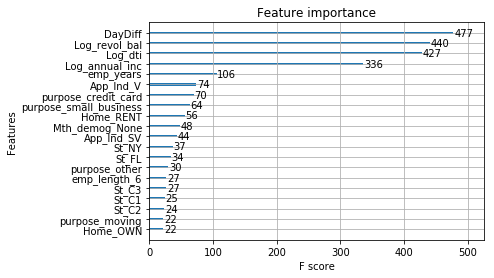

In [201]:
#Choose all predictors 
predictors = X_train.columns
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, X_train,y_train, X_test,y_test,predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50)

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_